# Мини-проект по статистике "Дисперсионный анализ"

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

### В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
### Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
 Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.



In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd 

#импортируем нужные библиотеки

In [91]:
task_1 = pd.read_csv('5_task_1.csv') #читаем файл
task_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [92]:
task_2 = pd.read_csv('5_task_2.csv') #читаем файл
task_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [93]:
pg.homoscedasticity(data = task_1, dv = 'events', group = 'group') 
#проверяем гомогенность дисперсии с помощью теста Левена
#нулевая гипотеза Левена, что Что дисперсии гомогенны. 
#Соответственно, альтернативная гипотеза - дисперсии гетерогенны (различаются)
#Вывод: результат теста True, дисперсии гомогенны 

,W,pval,equal_var
levene,2.26226,0.104133,True


In [94]:
task_1_A = task_1.query('group == "A"').events #делим данные на группы и выбираем колонку с самими данными

In [95]:
task_1_B = task_1.query('group == "B"').events 

In [96]:
task_1_C = task_1.query('group == "C"').events 

Проверяем, что данные распределены нормально, p-value больше, чем 0.05 - данные распределены нормально во всех трех группах
Используем именно scipy.stats.normaltest(), так как данный тест не такой чувствительный на большой выборке, как, например, метод Шапиро-Уилка.

In [97]:
st.normaltest(task_1_A) 

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [98]:
st.normaltest(task_1_B) 

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [99]:
st.normaltest(task_1_C) 

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

Проводим однофакторный дисперсионный анализ

In [100]:
st.f_oneway(task_1_A, task_1_B, task_1_C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Так как мы имеем дело со множественным сравнением и у нас повышается вероятность ошибки первого рода - мы используем поправку Тьюкки (не используем поправку Бонферрони, т.к. сильно повышается ошибка 2 рода).
Вывод: между всеми группами есть статистически значимые различия, это мы видим по колонке "reject"

In [54]:
pairwise_tukeyhsd(endog=task_1['events'], groups=task_1['group']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [105]:
task_2_test = task_2.query('group == "test"').events #снова делим данные на группы

In [102]:
task_2_cont_ = task_2.query('group == "control"').events

Для наглядности визуализируем распределение events для контрольной и тестовой групп

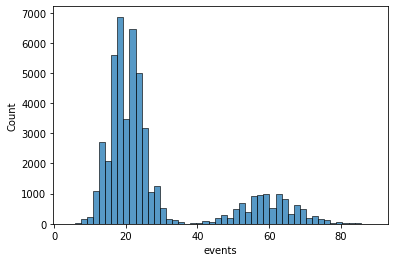

In [103]:
sns.histplot(task_2_cont_, bins = 50)

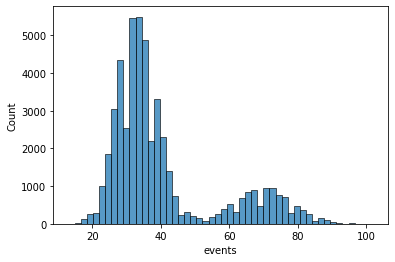

In [104]:
sns.histplot(task_2_test, bins = 50)

In [71]:
task_2_cont.query('segment == "high"').events.describe() #здесь находим медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя

count    10000.000000
mean        59.970800
std          7.805347
min         31.000000
25%         55.000000
50%         60.000000
75%         65.000000
max         89.000000
Name: events, dtype: float64

Далее нам предостоит сделать многофакторный дисперсионный анализ.
Для этого добавим новую колонку "combination", т.к. мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов. 

In [110]:
task_2 = task_2.assign(combination = task_2['group'] + ' \ ' + task_2['segment'])
task_2

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


In [111]:
formula = 'events ~ segment + group + segment:group' 

#зависимая_переменная ~ факторA + факторB + факторA:факторB

Из statsmodels.stats.multicomp мы берём функцию pairwise_tukeyhsd() . В качестве первого аргумента мы даём массив с зависимой переменной events , в качестве аргумента groups - массив с независимой переменной. Затем используем метод .summary() для вывода таблицы.

In [112]:
model = smf.ols(formula=formula, data=task_2).fit()
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [113]:
pairwise_tukeyhsd(endog=task_2['events'], groups=task_2['combination']).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


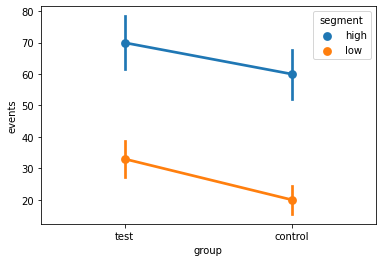

In [114]:
sns.pointplot(data=task_2, x='group', y='events', hue='segment', estimator=np.mean, ci='sd')

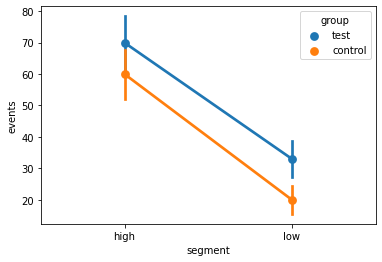

In [115]:
sns.pointplot(data=task_2, x='segment', y='events', hue='group', estimator=np.mean, ci='sd')

## Итог
Фактор group оказался значимым , фактор segment – значимым, их взаимодействие – значимо
Судя по графику, для всех групп среднее значение events - увеличилось
Поэтому решение: выкатываем новую версию.
